In [1]:
import pickle
import matplotlib.pyplot as plt
from torch import optim, nn, utils, Tensor
from torchvision.transforms import ToTensor
import pytorch_lightning as L
from pytorch_lightning import loggers as pl_loggers
import torch
import pdb
import numpy as np
from torchmetrics.text import CharErrorRate, WordErrorRate
import torchvision.transforms as transforms
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import Dataset
import xml.etree.ElementTree as ET
import glob
import os.path

In [2]:
all_chars = " ',-.:;ABCDEFGHIJKLMNOPQRSTUVWXabcdefghijklmnopqrstuvwxyz°¶–’"
print(len(all_chars))
char_to_num = {}
num_to_char = {}
for i in range(len(all_chars)):
    num_to_char[i+1] = all_chars[i]
    char_to_num[all_chars[i]] = i+1

61


In [3]:
class LineImageDataset(Dataset):
    def classify(self, line_im_filename):
        hash_num = (hash(line_im_filename) % 100) / 100
        if hash_num < 0.9: return "train"
        else: return "val"
    
    def __init__(self, dirname, char_to_num, num_to_char, data_type, transform=None):
        self.transform = transform       
        self.char_to_num = char_to_num
        self.num_to_char = num_to_char
        self.data_type = data_type
        self.line_images = []
        self.line_image_filenames = []
        self.labels = []
        self.num_labels = []
        
        #Iterate over all lines of all XML files
        ns = {'ns': 'http://schema.primaresearch.org/PAGE/gts/pagecontent/2013-07-15'}
        ET.register_namespace('', ns['ns'])

        #print(dirname)
        #print(glob.glob("./data/*.xml"))
        for filename in sorted(glob.glob(dirname + "/*.xml")):
            tree = ET.parse(filename)
            root = tree.getroot()

            image_filename = root.find('ns:Page', ns).get('imageFilename')

            #First iteration: calculate average line spacing
            for text_region in root.findall('.//ns:TextRegion', ns):
                for lineno, text_line in enumerate(text_region.findall('.//ns:TextLine', ns)):                    
                    line_im_filename = dirname + "/line_{}_{}".format(lineno, image_filename)
                    line_im_filename, _ = os.path.splitext(line_im_filename)
                    line_im_filename += ".png"
                    if self.classify(line_im_filename) != data_type:
                        continue
                        
                    self.line_image_filenames.append(line_im_filename)
                    #self.line_images.append(read_image(line_im_filename, ImageReadMode.GRAY))   
                    self.line_images.append(torch.tensor(np.load(line_im_filename.replace(".png", ".npy")), dtype=torch.float32).unsqueeze(0))
                    
                    text = text_line.find('.//ns:TextEquiv', ns).find('.//ns:Unicode', ns).text
                    self.labels.append(text)
                    self.num_labels.append(torch.tensor([self.char_to_num[c] for c in text]))
                                        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):                
        image = torch.clone(self.line_images[idx])
        
        if self.transform is not None:
            #median = torch.median(image)
            image = self.transform(image)
            #image[image == -1] = torch.median(image)
       
        return {"image": image, "target": self.num_labels[idx], "text": self.labels[idx]}


In [4]:
train_transform = transforms.Compose(
    [
        #transforms.ToPILImage(),
       # transforms.ColorJitter(0.5, 0.5, 0.5, 0.5),
       # transforms.RandomAffine(0.7, translate=(0.01, 0.02), scale=(0.98, 1.02)),
       # transforms.RandomChoice([
       #     transforms.RandomAdjustSharpness(2, p=0.5),
       #     transforms.GaussianBlur(21, (1,6))
       # ]),
        #transforms.RandomEqualize(p=1),
        #transforms.ToTensor(),        
        #transforms.Normalize(0.5, 0.12)
    ])

val_transform = transforms.Compose(
    [
        #transforms.ToPILImage(),
        #transforms.RandomEqualize(p=1),
        #transforms.ToTensor(),        
        #transforms.Normalize(0.5, 0.12)
    ])

train_dataset = LineImageDataset("data/", char_to_num, num_to_char, data_type="train", transform=train_transform)
val_dataset = LineImageDataset("data/", char_to_num, num_to_char, data_type="val", transform=val_transform)

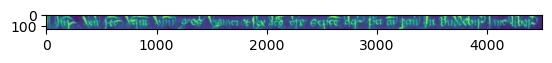

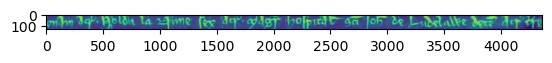

In [5]:
plt.imshow(torch.tensor(np.load("data/line_0_0001_JUST1-734m5d.npy")))
plt.figure()
plt.imshow(train_dataset[20]["image"][0])

In [6]:
type(train_dataset[20]["image"])

torch.Tensor

In [7]:
# class MyNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(1, 32, (4,16), padding=(1,7)),
#             nn.ReLU(),
#             nn.Dropout2d(0.1),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            
#             nn.Conv2d(32, 32, (4,16), padding=(1,7)),
#             nn.ReLU(),
#             nn.Dropout2d(0.1),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            
#             nn.Conv2d(32, 64, (3,8), padding=(1,3)),
#             nn.ReLU(),
#             nn.Dropout2d(0.1),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            
#             nn.Conv2d(64, 64, (3,8), padding=(1,3)),
#             nn.ReLU(),
#             nn.Dropout2d(0.1)
#         )
        
#         self.lstms = nn.ModuleList([
#             nn.LSTM(960, 256, bidirectional=True, batch_first=True),
#             nn.Dropout(0.3),
#             nn.LSTM(512, 256, bidirectional=True, batch_first=True),
#             nn.Dropout(0.3),
#             nn.LSTM(512, 256, bidirectional=True, batch_first=True),
#             nn.Dropout(0.3),
#         ])
#         self.lin = nn.Linear(512, 62)

#     def forward(self, x):
#         x = self.features(x)
#         x = x.contiguous().view(-1, x.shape[1] * x.shape[2], x.shape[3]).transpose(1,2)
#         #x = x.contiguous().view(x.shape[0], x.shape[3], x.shape[1] * x.shape[2])
        
#         for layer in self.lstms:
#             if isinstance(layer, nn.LSTM):
#                 x, _ = layer(x)
#             else:
#                 x = layer(x)      
#         x = self.lin(x)
#         x = nn.functional.log_softmax(x, dim=2)
#         return x.transpose(1,2)

# net = MyNN()

In [8]:
class MyNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, (4,16), padding=(1,7)),
            nn.ReLU(),
            nn.BatchNorm2d(32),            
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            nn.Conv2d(32, 32, (4,16), padding=(1,7)),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            nn.Conv2d(32, 64, (3,8), padding=(1,3)),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            nn.Conv2d(64, 64, (3,8), padding=(1,3)),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        
        self.lstms = nn.ModuleList([
            nn.LSTM(960, 256, bidirectional=True, batch_first=True),
            #nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.LSTM(512, 256, bidirectional=True, batch_first=True),
            nn.Dropout(0.3),
            #nn.BatchNorm1d(256),
            nn.LSTM(512, 256, bidirectional=True, batch_first=True),
            nn.Dropout(0.3),
        ])
        self.lin = nn.Linear(512, 62)

    def forward(self, x):
        x = self.features(x)
        x = x.contiguous().view(-1, x.shape[1] * x.shape[2], x.shape[3]).transpose(1,2)
        #x = x.contiguous().view(x.shape[0], x.shape[3], x.shape[1] * x.shape[2])
        
        for layer in self.lstms:
            if isinstance(layer, nn.LSTM):
                x, _ = layer(x)
            else:
                x = layer(x)      
        x = self.lin(x)
        x = nn.functional.log_softmax(x, dim=2)
        return x.transpose(1,2)

net = MyNN()

In [9]:
#device = torch.device("cuda")

class LatinTranscriber(L.LightningModule):
    def __init__(self, net, codec_l2c):
        super().__init__()
        self.codec_l2c = codec_l2c
        self.cer_calc = CharErrorRate()
        self.wer_calc = WordErrorRate()
        self.train_cer_calc = CharErrorRate()
        self.train_wer_calc = WordErrorRate()
        self.net = net
                
    def get_loss(self, batch, batch_idx):
        #input, _, target = batch
        
        target = batch["target"]
        target_length = batch["target"].shape[1]
       
        #self.net = self.net.to(device)
        input = batch["image"]#.to(device)
        
        #output, _ = self.net(input)
        output = self.net(input)
        #print("Output shape", output.shape)
        # height should be 1 by now
        #if output.size(2) != 1:
        #    raise ValueError('Expected dimension 3 to be 1, actual {}'.format(output.size(2)))
        #output = output.squeeze(2)
        
        output_length = output.shape[-1]
        
        loss_func = nn.CTCLoss(reduction='sum', zero_infinity=True)
        loss = loss_func(output.permute(2,0,1), target, (output_length,), (target_length,))
        return loss, output
    
    def on_train_epoch_start(self):
        self.train_cer_calc.reset()
        self.train_wer_calc.reset()
        
        
    def _get_current_lr(self):
        for param_group in self.trainer.optimizers[0].param_groups:
            return param_group['lr']
        
    def on_train_epoch_end(self):
        char_accuracy = 1 - self.train_cer_calc.compute()
        word_accuracy = 1 - self.train_wer_calc.compute()
        lr = self._get_current_lr()
        
        self.log("train_char_acc", char_accuracy)
        self.log("train_word_acc", word_accuracy)
        self.log('lr-Adam', lr)

    def training_step(self, batch, batch_idx):
        assert self.net.training
        loss, output = self.get_loss(batch, batch_idx)
        prediction, truth = self.get_prediction_and_truth(output, batch["target"])
        self.train_cer_calc.update(truth, prediction)
        self.train_wer_calc.update(truth, prediction)
        self.log("train_loss", loss)
        return loss
    
    def get_prediction_and_truth(self, output, target):
        target = torch.squeeze(target).cpu().numpy()
        #truth = ''.join([self.codec_l2c[(target[i].item(),)] for i in range(len(target))])        
        truth = ''.join([self.codec_l2c[target[i].item()] for i in range(len(target))])  
        labels = torch.argmax(torch.squeeze(output), axis=0).cpu().numpy()
        prediction = ""
        for i in range(len(labels)):
            label = labels[i]
            if label != 0 and (i==0 or label != labels[i-1]):
                #prediction += self.codec_l2c[(label,)]
                prediction += self.codec_l2c[label]
                
        return prediction, truth
    
    def validation_step(self, batch, batch_idx):
        assert not self.net.training
        assert batch["target"].shape[0] == 1
        loss, output = self.get_loss(batch, batch_idx)
        prediction, truth = self.get_prediction_and_truth(output, batch["target"])
        self.cer_calc.update(truth, prediction)
        self.wer_calc.update(truth, prediction)
        
        # Get tensorboard logger
        if batch_idx < 16:
            tb_logger = None
            for logger in self.trainer.loggers:
                if isinstance(logger, pl_loggers.TensorBoardLogger):
                    tb_logger = logger.experiment
                    break

            tb_logger.add_image(f'Validation #{batch_idx}, target: {truth}', batch['image'][0], self.global_step, dataformats="CHW")
            tb_logger.add_text(f'Validation #{batch_idx}, target: {truth}', prediction, self.global_step)

        return loss
    
    def on_validation_epoch_start(self):
        self.cer_calc.reset()
        self.wer_calc.reset()
        
    def on_validation_epoch_end(self):
        char_accuracy = 1 - self.cer_calc.compute()
        word_accuracy = 1 - self.wer_calc.compute()
        print("Epoch, char acc, word acc:", self.current_epoch, round(char_accuracy.item(), 4), round(word_accuracy.item(), 4))
        self.log("val_char_acc", char_accuracy)
        self.log("val_word_acc", word_accuracy)


    def configure_optimizers(self):        
        optimizer = optim.AdamW(self.parameters(), lr=1e-3, weight_decay=1e-2)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "name": "lr-scheduler",
                "scheduler": optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.34, min_lr=1e-4, patience=15),
                "monitor": "val_word_acc",
                "frequency": 1
            },
        }
        
        #optimizer = optim.AdamW(self.parameters(), lr=1e-3, weight_decay=1e-2)        
        #return optimizer

transcriber = LatinTranscriber(net, num_to_char)

tensor(-0.4013) tensor(1.3742)


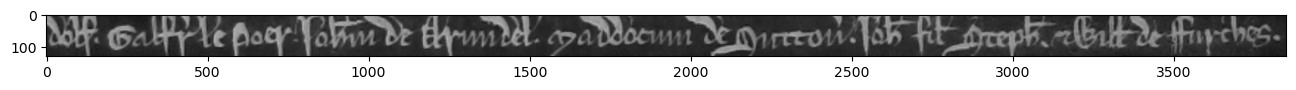

In [10]:
plt.figure(figsize=(16,6))
idx = 10
print(torch.min(val_dataset[idx]["image"]), torch.max(val_dataset[idx]["image"]))
plt.imshow(val_dataset[idx]["image"][0], cmap="gray", vmin=-0.5, vmax=2)

In [11]:
#train_set_size = int(len(dataset) * 0.9)
#valid_set_size = len(dataset) - train_set_size

# split the train set into two
#seed = torch.Generator().manual_seed(40)
#train_set, valid_set = torch.utils.data.random_split(dataset, [train_set_size, valid_set_size], generator=seed)

train_loader = utils.data.DataLoader(train_dataset, num_workers=4)
valid_loader = utils.data.DataLoader(val_dataset, num_workers=4)

In [12]:
trainer = L.Trainer(accumulate_grad_batches=1, max_epochs=500)
trainer.fit(transcriber, train_loader, valid_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params
-------------------------------------------------
0 | cer_calc       | CharErrorRate | 0     
1 | wer_calc       | WordErrorRate | 0     
2 | train_cer_calc | CharErrorRate | 0     
3 | train_wer_calc | WordErrorRate | 0     
4 | net            | MyNN          | 5.9 M 
-------------------------------------------------
5.9 M     Trainable params
0         Non-trainable params
5.9 M   

Sanity Checking: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 0 -37.6667 -17.5


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 0 -inf -inf


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 1 -1.9312 -0.3875


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 2 -0.7267 -0.0755


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 3 0.0329 0.0434


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 4 0.2655 0.0978


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 5 0.4063 0.1382


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 6 0.5172 0.1729


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 7 0.5889 0.2323


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 8 0.6221 0.2682


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 9 0.6253 0.2799


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 10 0.6468 0.3038


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 11 0.6592 0.322


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 12 0.6871 0.3349


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 13 0.6912 0.3507


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 14 0.688 0.3531


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 15 0.7029 0.356


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 16 0.7199 0.377


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 17 0.7178 0.3919


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 18 0.7053 0.3652


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 19 0.722 0.3808


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 20 0.7345 0.3987


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 21 0.7175 0.3804


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 22 0.7306 0.3931


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 23 0.7252 0.3662


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 24 0.7397 0.4189


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 25 0.7351 0.392


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 26 0.7336 0.3864


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 27 0.7323 0.4007


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 28 0.741 0.3958


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 29 0.7513 0.4089


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 30 0.7299 0.3903


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 31 0.7477 0.3923


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 32 0.751 0.4092


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 33 0.7412 0.4033


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 34 0.7499 0.4167


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 35 0.747 0.4133


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 36 0.7609 0.427


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 37 0.745 0.4305


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 38 0.7553 0.4341


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 39 0.7628 0.4314


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 40 0.7608 0.428


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 41 0.7588 0.4071


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 42 0.7518 0.4157


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 43 0.7573 0.4322


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 44 0.7738 0.4539


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 45 0.7296 0.4197


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 46 0.7635 0.4225


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 47 0.7517 0.4167


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 48 0.7575 0.4261


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 49 0.7741 0.4359


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 50 0.7786 0.457


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 51 0.7769 0.4493


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 52 0.7771 0.4441


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 53 0.7666 0.4313


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 54 0.7691 0.4276


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 55 0.769 0.4527


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 56 0.7671 0.4308


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 57 0.7672 0.449


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 58 0.7792 0.4432


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 59 0.7791 0.455


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 60 0.7892 0.4536


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 61 0.7837 0.4646


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 62 0.7841 0.4429


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 63 0.76 0.4126


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 64 0.7793 0.4577


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 65 0.782 0.4426


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 66 0.7834 0.4676


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 67 0.7963 0.4726


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 68 0.7938 0.4819


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 69 0.7864 0.4707


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 70 0.776 0.451


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 71 0.794 0.4764


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 72 0.7809 0.4638


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 73 0.7895 0.4709


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 74 0.793 0.4462


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 75 0.7919 0.4596


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 76 0.7981 0.4772


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 77 0.7879 0.4664


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 78 0.7951 0.4718


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 79 0.7882 0.483


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 80 0.7944 0.4772


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 81 0.7688 0.4392


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 82 0.7801 0.4651


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 83 0.7984 0.4858


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 84 0.7907 0.4732


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 85 0.8063 0.4932


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 86 0.8032 0.4959


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 87 0.7953 0.4758


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 88 0.8021 0.4844


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 89 0.8014 0.4868


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 90 0.7903 0.4745


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 91 0.7992 0.4674


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 92 0.7985 0.4814


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 93 0.7926 0.4713


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 94 0.8015 0.4813


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 95 0.8083 0.5023


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 96 0.7947 0.4591


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 97 0.8064 0.4923


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 98 0.7931 0.4624


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 99 0.7971 0.4881


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 100 0.7927 0.49


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 101 0.7981 0.4812


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 102 0.798 0.4918


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 103 0.7992 0.4722


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 104 0.8076 0.4846


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 105 0.8007 0.4963


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 106 0.8017 0.4982


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 107 0.7987 0.4768


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 108 0.7988 0.4748


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 109 0.7824 0.4488


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 110 0.7941 0.4611


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 111 0.7927 0.4688


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 112 0.8318 0.5191


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 113 0.8357 0.5312


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 114 0.839 0.5326


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 115 0.8393 0.5312


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 116 0.8369 0.5385


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 117 0.8369 0.533


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 118 0.8382 0.5406


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 119 0.8382 0.5332


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 120 0.8397 0.537


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 121 0.835 0.5416


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 122 0.834 0.5188


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 123 0.8361 0.5309


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 124 0.8398 0.5362


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 125 0.8388 0.5443


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 126 0.8426 0.5371


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 127 0.8399 0.5221


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 128 0.837 0.529


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 129 0.8398 0.5291


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 130 0.843 0.5491


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 131 0.8395 0.5431


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 132 0.8423 0.5434


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 133 0.8394 0.5308


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 134 0.8383 0.5434


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 135 0.838 0.539


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 136 0.8357 0.5411


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 137 0.8412 0.5512


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 138 0.8355 0.5299


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 139 0.8348 0.5378


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 140 0.8394 0.5441


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 141 0.8341 0.5398


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 142 0.8311 0.5437


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 143 0.8359 0.5469


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 144 0.8395 0.5514


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 145 0.8375 0.5482


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 146 0.8371 0.5414


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 147 0.8335 0.5374


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 148 0.8325 0.5338


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 149 0.8367 0.5427


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 150 0.8414 0.5544


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 151 0.8385 0.5438


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 152 0.8345 0.5266


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 153 0.8321 0.5191


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 154 0.8374 0.5273


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 155 0.8311 0.5398


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 156 0.837 0.5455


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 157 0.8346 0.5508


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 158 0.8343 0.5482


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 159 0.8357 0.5419


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 160 0.8359 0.5522


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 161 0.8368 0.5443


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 162 0.8357 0.5399


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 163 0.8358 0.5439


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 164 0.8345 0.5414


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 165 0.8395 0.5566


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 166 0.8398 0.5478


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 167 0.8363 0.5373


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 168 0.8396 0.5532


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 169 0.8392 0.5484


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 170 0.8374 0.5426


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 171 0.8407 0.5533


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 172 0.837 0.5465


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 173 0.84 0.5532


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 174 0.8371 0.5421


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 175 0.8394 0.5419


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 176 0.8353 0.5432


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 177 0.832 0.5326


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 178 0.8397 0.5459


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 179 0.8373 0.5401


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 180 0.8337 0.5357


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 181 0.8363 0.539


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 182 0.8422 0.5481


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 183 0.8427 0.5486


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 184 0.8419 0.5472


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 185 0.844 0.5505


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 186 0.8438 0.5495


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 187 0.8455 0.5567


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 188 0.8432 0.5592


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 189 0.8397 0.5482


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 190 0.8418 0.5531


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 191 0.8435 0.5572


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 192 0.8448 0.5542


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 193 0.8435 0.5468


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 194 0.8441 0.5603


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 195 0.8388 0.5491


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 196 0.8413 0.5483


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 197 0.8397 0.5512


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 198 0.8421 0.5512


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 199 0.8429 0.558


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 200 0.8416 0.5545


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 201 0.8408 0.5589


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 202 0.8415 0.5553


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 203 0.842 0.5548


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 204 0.8409 0.5532


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 205 0.8434 0.5562


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 206 0.8438 0.5573


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 207 0.8435 0.5508


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 208 0.8403 0.548


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 209 0.8428 0.5618


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 210 0.8423 0.5615


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 211 0.8449 0.566


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 212 0.8452 0.5617


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 213 0.8437 0.5663


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 214 0.8427 0.5639


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 215 0.84 0.568


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 216 0.8395 0.5599


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 217 0.8391 0.5585


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 218 0.8399 0.5608


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 219 0.8386 0.5574


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 220 0.8395 0.5568


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 221 0.8387 0.5582


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 222 0.844 0.5639


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 223 0.8414 0.5601


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 224 0.84 0.5537


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 225 0.8434 0.5579


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 226 0.8408 0.5527


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 227 0.8402 0.5508


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 228 0.8398 0.5541


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 229 0.8413 0.5536


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 230 0.8423 0.5544


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 231 0.8385 0.5536


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 232 0.8397 0.553


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 233 0.8413 0.5565


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 234 0.8403 0.5527


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 235 0.841 0.5577


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 236 0.8393 0.5496


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 237 0.8406 0.5531


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 238 0.8417 0.5557


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 239 0.8427 0.5592


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 240 0.8418 0.5599


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 241 0.8411 0.5613


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 242 0.845 0.5692


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 243 0.8401 0.558


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 244 0.8409 0.5545


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 245 0.8445 0.5612


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 246 0.8451 0.5585


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 247 0.8452 0.5631


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 248 0.8457 0.5613


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 249 0.8458 0.5633


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 250 0.8428 0.5575


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 251 0.8426 0.5588


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 252 0.8445 0.5587


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 253 0.8449 0.5673


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 254 0.8464 0.5672


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 255 0.848 0.5674


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 256 0.8494 0.565


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 257 0.8455 0.5603


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 258 0.8475 0.5662


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 259 0.8436 0.5566


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 260 0.8475 0.5696


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 261 0.8429 0.5575


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 262 0.8448 0.5673


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 263 0.8447 0.5626


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 264 0.8438 0.5541


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 265 0.8424 0.5566


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 266 0.8445 0.5653


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 267 0.8444 0.5637


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 268 0.8428 0.5623


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 269 0.8432 0.5627


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 270 0.8441 0.5614


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 271 0.8453 0.565


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 272 0.8448 0.5655


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 273 0.8454 0.5628


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 274 0.8437 0.5615


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 275 0.8419 0.5653


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 276 0.8417 0.5605


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 277 0.842 0.5599


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 278 0.8413 0.5588


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 279 0.8432 0.5599


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 280 0.8453 0.5663


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 281 0.8432 0.5627


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 282 0.8405 0.5576


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 283 0.8431 0.5591


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 284 0.8417 0.5622


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 285 0.841 0.5604


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 286 0.8437 0.5601


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 287 0.8431 0.5572


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 288 0.8437 0.5621


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 289 0.843 0.5586


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 290 0.8449 0.5622


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 291 0.841 0.5577


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 292 0.8419 0.5586


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 293 0.8419 0.5631


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 294 0.8441 0.5587


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 295 0.8447 0.5547


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 296 0.8442 0.5537


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 297 0.8485 0.5624


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 298 0.845 0.5563


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 299 0.8457 0.5633


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 300 0.844 0.5597


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 301 0.8443 0.5583


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 302 0.8441 0.5618


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 303 0.8437 0.5624


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 304 0.8468 0.5685


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 305 0.8453 0.5672


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 306 0.842 0.5533


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 307 0.8457 0.5693


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 308 0.848 0.5719


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 309 0.848 0.571


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 310 0.8453 0.564


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 311 0.846 0.5626


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 312 0.8468 0.5664


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 313 0.8461 0.5578


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 314 0.8462 0.5656


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 315 0.8435 0.5614


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 316 0.8451 0.5637


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 317 0.8422 0.5576


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 318 0.8434 0.5591


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 319 0.8439 0.5631


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 320 0.8388 0.5461


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 321 0.8421 0.5523


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 322 0.8417 0.5565


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 323 0.8406 0.5536


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 324 0.8441 0.5618


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 325 0.8399 0.5564


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 326 0.8435 0.5654


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 327 0.8417 0.5615


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 328 0.8414 0.5596


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 329 0.8399 0.5571


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 330 0.8395 0.5509


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 331 0.84 0.5558


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 332 0.842 0.5647


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 333 0.8425 0.5635


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 334 0.8427 0.5559


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 335 0.8452 0.5573


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 336 0.8411 0.5513


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 337 0.8446 0.5651


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 338 0.8443 0.565


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 339 0.8428 0.5619


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 340 0.8412 0.5562


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 341 0.841 0.5567


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 342 0.8454 0.5572


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 343 0.8426 0.5559


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 344 0.8451 0.5666


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 345 0.8462 0.5629


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 346 0.8458 0.5612


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 347 0.8443 0.559


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 348 0.8437 0.5491


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 349 0.8429 0.5529


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 350 0.8453 0.5551


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 351 0.8459 0.5575


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 352 0.8448 0.5573


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 353 0.8436 0.5503


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 354 0.8463 0.5522


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 355 0.8469 0.5586


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 356 0.8475 0.5609


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 357 0.8469 0.5641


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 358 0.8463 0.5582


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 359 0.8455 0.5565


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 360 0.8483 0.561


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 361 0.8472 0.5621


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 362 0.8481 0.5654


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 363 0.8453 0.5596


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 364 0.847 0.5603


/home/stanley/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [13]:
#torch.save(net.state_dict(), "my_custom_best.pt") %94% char, 82% word
#torch.save(net.state_dict(), "my_aguillar_repro.pt") #91% char, 69% word